In [1]:
!pip install langgraph langsmith


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 824.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 9.5 MB/s eta 0:00:00


In [2]:
!pip install langchain langchain_groq langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.0 MB/s eta 0:00:00


In [3]:
from google.colab import userdata
groq_api_key = userdata.get('groq_api_key')
langsmith_api_key = userdata.get('LANGSMITH_API_KEY')

In [4]:
import os
os.environ["LANGSMITH_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph"

In [5]:
from typing import Annotated
from typing_extensions import TypedDict

In [6]:
## Working tools

from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun



In [7]:
!pip install  wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=46268a422df2d7647569b88628168af100268d3336bd794b928a0a98d54727e9
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [8]:
wikipedia_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper,name="wikipedia",
    description="Useful for looking up information about people, places, or topics on Wikipedia.")


In [9]:
wikipedia_tool.invoke(
    "WHO is Virat Kohli "
)

'Page: Virat Kohli\nSummary: Virat Kohli (Hindi pronunciation: [ʋɪˈɾaːʈᵊ ˈkoːɦᵊliː] , born 5 November 1988) is an Indian international cricketer and the former captain of the Indian national cricket team. He is a right-handed batsman and an occasional medium-fast bowler. He currently represents Royal '

In [10]:
tools=[wikipedia_tool]

In [11]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [12]:
class State(TypedDict):
  messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

In [13]:
graph_builder

In [14]:
from langchain_groq import ChatGroq

In [15]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.1-8b-instant")

In [16]:
llm_with_tools=llm.bind_tools(tools)

In [17]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state['messages'])]}

In [18]:
from langgraph.prebuilt import ToolNode,tools_condition

In [19]:
graph_builder.add_edge(START,"chatbot")
# ✅ Add chatbot2 node first
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")


# ✅ Connect tools back to chatbot
graph_builder.add_edge("tools", "chatbot")

# ✅ End the flow after chatbot if no more actions
graph_builder.add_edge("chatbot", END)


In [20]:
graph=graph_builder.compile()

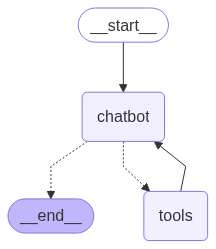

In [21]:
from IPython.display import display,Image

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception :
  pass

In [46]:
user_input="What are you doing"

events = graph.stream(
    {"messages":[("user",user_input)]}, stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================ Human Message =================================

What are you doing
================================== Ai Message ==================================

I'm a text-based AI assistant, and my main function is to assist and communicate with users through text-based conversations. I can provide information on a wide range of topics, answer questions, and even engage in creative writing or conversation. I'm constantly learning and improving my knowledge base, so I can respond to a variety of questions and prompts.
